# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import seaborn as sns
from scipy.stats import norm
from scipy.stats import ttest_ind, ttest_rel, ranksums, wilcoxon

In [3]:
from backend import data_paths
from backend import evaluation_utils
from backend import metrics_utils

# Load Return Period Metrics

In [4]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_1980_RETURN_PERIOD_METRICS_DIR,
}

In [5]:
precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.CONCATENATED_RETURN_PERIOD_DICTS_DIR / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



# Global Precision & Recall Distributions

/tmp/ipykernel_1331542/2761817911.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(
/tmp/ipykernel_1331542/2761817911.py:154: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


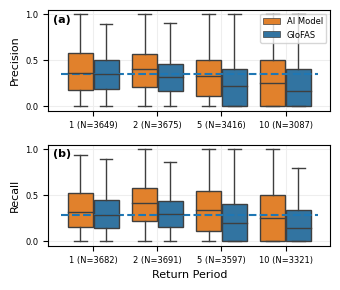

In [21]:
lead_time = 0
baseline_experiment = 'kfold_splits'
comparison_experiment = metrics_utils.GLOFAS_VARIABLE
use_return_periods = evaluation_utils.RETURN_PERIODS[:-2]

fig, axes = plt.subplots(
    2, 1, 
    figsize=(
        evaluation_utils.NATURE_FIG_SIZES['one_column'], 
        evaluation_utils.NATURE_FIG_SIZES['one_column']*6/7
    )
)

# -----

metric = 'Precision'
df1 = precisions_by_lead_time['google_1980'][baseline_experiment][lead_time][use_return_periods].copy()
df2 = precisions_by_lead_time['glofas_1980'][comparison_experiment][lead_time][use_return_periods].copy()

# Make sure that we compare apples to apples by dropping any gauge with a nan from either model.
for return_period in use_return_periods:
    df_merged = pd.concat(
        [
            df1[return_period].rename('google'),
            df2[return_period].rename('glofas')
        ], axis=1).dropna()
    df1[return_period] = df_merged['google'].rename(return_period)
    df2[return_period] = df_merged['glofas'].rename(return_period)

df1['Model'] = evaluation_utils.EXPERIMENT_NAMES[baseline_experiment]
df2['Model'] = evaluation_utils.EXPERIMENT_NAMES[comparison_experiment]
df = pd.concat([df1, df2,], axis=0)
df.reset_index(inplace=True)
dd = pd.melt(
    df, 
    id_vars=['index', 'Model'], 
    value_vars=use_return_periods, 
    var_name='Return Period'
)
dd.rename(columns={'value': metric}, inplace=True)

# Add sample size to x-tick labels
dd.dropna(inplace=True)
dd['Return Period'] = [int(val) for val in dd['Return Period']]
return_period_sample_size = dd['Return Period'].value_counts()
dd['Return Period'] = [f'{val} (N={int(return_period_sample_size[val]/2)})' for val in dd['Return Period']]

bp_colors = [evaluation_utils.COLORS[1], evaluation_utils.COLORS[0]]
bp = sns.boxplot(
    ax=axes[0], 
    data=dd, 
    x='Return Period', 
    y=metric, 
    hue='Model', 
    showfliers=False, 
    palette=bp_colors,
    linewidth=1
)
axes[0].grid(c='#EEE')
axes[0].set_axisbelow(True)
axes[0].get_legend()
axes[0].set_xlabel(None)
axes[0].set_xticklabels(
    axes[0].get_xticklabels(),
    fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels']
)
axes[0].set_yticklabels(
    axes[0].get_yticklabels(),
    fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels']
)
axes[0].set_xlabel(None)

axes[0].legend(
    loc='upper right', 
    fontsize=evaluation_utils.NATURE_FONT_SIZES['legend']
)
axes[0].set_ylabel(
    metric,
    fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label'],
)

axes[0].plot(
    [-0.5, 3.5], 
    [df2[1.01].median()]*2, 
    c=evaluation_utils.COLORS[0], 
    ls='--'
)

axes[0].text(
    -0.63, 1,
    '(a)',
    fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label'],
    va='top',
    fontweight="bold"
)

# -----

metric = 'Recall'
df1 = recalls_by_lead_time['google_1980'][baseline_experiment][lead_time][use_return_periods].copy()
df2 = recalls_by_lead_time['glofas_1980'][comparison_experiment][lead_time][use_return_periods].copy()

# Make sure that we compare apples to apples by dropping any gauge with a nan from either model.
for return_period in use_return_periods:
    df_merged = pd.concat(
        [
            df1[return_period].rename('google'),
            df2[return_period].rename('glofas')
        ], axis=1).dropna()
    df1[return_period] = df_merged['google'].rename(return_period)
    df2[return_period] = df_merged['glofas'].rename(return_period)

df1['Model'] = evaluation_utils.EXPERIMENT_NAMES[baseline_experiment]
df2['Model'] = evaluation_utils.EXPERIMENT_NAMES[comparison_experiment]
df = pd.concat([df1, df2], axis=0)
df.reset_index(inplace=True)
dd = pd.melt(
    df, 
    id_vars=['index', 'Model'], 
    value_vars=use_return_periods, 
    var_name='Return Period'
)
dd.rename(columns={'value': metric}, inplace=True)
dd['Return Period'] = [int(val) for val in dd['Return Period']]

# Add sample size to x-tick labels
dd.dropna(inplace=True)
dd['Return Period'] = [int(val) for val in dd['Return Period']]
return_period_sample_size = dd['Return Period'].value_counts()
dd['Return Period'] = [f'{val} (N={int(return_period_sample_size[val]/2)})' for val in dd['Return Period']]

bp_colors = [evaluation_utils.COLORS[1], evaluation_utils.COLORS[0]]
bp = sns.boxplot(
    ax=axes[1], 
    data=dd, 
    x='Return Period', 
    y=metric, 
    hue='Model', 
    showfliers=False, 
    palette=bp_colors,
    linewidth=1
)
axes[1].grid(c='#EEE')
axes[1].set_axisbelow(True)
axes[1].legend().remove()
axes[1].set_xlabel(
    'Return Period', 
    fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label']
)
axes[1].set_xticklabels(
    axes[1].get_xticklabels(),
    fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels']
)
axes[1].set_yticklabels(
    axes[1].get_yticklabels(),
    fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels']
)
axes[1].set_ylabel(
    metric,
    fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label'],
)

axes[1].plot(
    [-0.5, 3.5], 
    [df2[1.01].median()]*2, 
    c=evaluation_utils.COLORS[0], 
    ls='--'
)

axes[1].text(
    -0.63, 1,
    '(b)',
    fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label'],
    va='top',
    fontweight="bold"
)

plt.tight_layout()

evaluation_utils.save_figure(data_paths.RETURN_PERIOD_RELIABILITY_DISTRIBUTIONS_FILENAME)

# Statistical Significance of Differences with GloFAS

In [7]:
for return_period in evaluation_utils.RETURN_PERIODS:
    print(f'--- {return_period=} --------------------------------')
    precision_tests = pd.concat(
        [
            precisions_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][lead_time][return_period].rename('glofas'),
            precisions_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('google')
        ], 
        axis=1
    ).dropna()
#     print(ttest_ind(precision_tests['glofas'], precision_tests['google']))
#     print(ttest_rel(precision_tests['glofas'], precision_tests['google']))
#     print(ranksums(precision_tests['glofas'], precision_tests['google']))
    stats = wilcoxon(precision_tests['glofas'], precision_tests['google'])
    cohen_d = evaluation_utils.cohen_d(precision_tests['google'].values, precision_tests['glofas'].values)
    zstatistic = norm.isf(stats.pvalue / 2)
    n = precision_tests.shape[0]
    effect_size = zstatistic / n**(1/2)
    print(stats, effect_size, cohen_d, n)
    print('-------------------------------------------------------\n\n')
 

--- return_period=1.01 --------------------------------
WilcoxonResult(statistic=2293172.0, pvalue=2.435736801390481e-49) 0.24443802810572712 0.1551644609446731 3649
-------------------------------------------------------


--- return_period=2 --------------------------------
WilcoxonResult(statistic=1771353.0, pvalue=1.7173869560610012e-108) 0.36500954440459743 0.30974334599866754 3675
-------------------------------------------------------


--- return_period=5 --------------------------------
WilcoxonResult(statistic=1084650.0, pvalue=3.259385555900583e-101) 0.36543431225754536 0.34769217953375703 3416
-------------------------------------------------------


--- return_period=10 --------------------------------
WilcoxonResult(statistic=695102.0, pvalue=7.310400094893004e-46) 0.25586047314002947 0.26542342061649304 3087
-------------------------------------------------------


--- return_period=20 --------------------------------
WilcoxonResult(statistic=187226.0, pvalue=1.702550620

In [8]:
for return_period in evaluation_utils.RETURN_PERIODS:
    print(f'--- {return_period=} --------------------------------')
    recalls_tests = pd.concat(
        [
            recalls_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][lead_time][return_period].rename('glofas'),
            recalls_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('google')
        ], 
        axis=1
    ).dropna()
#     print(ttest_ind(recalls_tests['glofas'], recalls_tests['google']))
#     print(ttest_rel(recalls_tests['glofas'], recalls_tests['google']))
#     print(ranksums(recalls_tests['glofas'], recalls_tests['google']))
    stats = wilcoxon(recalls_tests['glofas'], recalls_tests['google'])
    cohen_d = evaluation_utils.cohen_d(recalls_tests['google'].values, recalls_tests['glofas'].values)
    zstatistic = norm.isf(stats.pvalue / 2)
    n = recalls_tests.shape[0]
    effect_size = zstatistic / n**(1/2)
    print(stats, effect_size, cohen_d, n)
    print('-------------------------------------------------------\n\n')
 

--- return_period=1.01 --------------------------------
WilcoxonResult(statistic=2106767.5, pvalue=3.0701822506410695e-67) 0.2855093917847065 0.2098445648631995 3682
-------------------------------------------------------


--- return_period=2 --------------------------------
WilcoxonResult(statistic=1025664.0, pvalue=2.048992293829381e-211) 0.5107706300240906 0.46875479087110594 3691
-------------------------------------------------------


--- return_period=5 --------------------------------
WilcoxonResult(statistic=756990.0, pvalue=1.6496172457652325e-125) 0.39732502948641507 0.3887982316388989 3597
-------------------------------------------------------


--- return_period=10 --------------------------------
WilcoxonResult(statistic=457585.5, pvalue=2.850941468696851e-61) 0.28658276331869936 0.28996373922423785 3321
-------------------------------------------------------


--- return_period=20 --------------------------------
WilcoxonResult(statistic=151654.5, pvalue=3.538554884648

# Significance of Differences between Mismatched Return Periods

In [9]:
lead_time = 0

print('--- Precision 1-year ------------------------------------')

precision_tests = pd.concat(
    [
        precisions_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][lead_time][1.01].rename('glofas'),
        precisions_by_lead_time['google_1980']['kfold_splits'][lead_time][5.00].rename('google')
    ], axis=1
).dropna()
# print(ttest_ind(precision_tests['glofas'], precision_tests['google']))
# print(ttest_rel(precision_tests['glofas'], precision_tests['google']))
# print(ranksums(precision_tests['glofas'], precision_tests['google']))
diffsum = sum(precision_tests['glofas'] - precision_tests['google'])
stats = wilcoxon(precision_tests['glofas'], precision_tests['google'])
cohen_d = evaluation_utils.cohen_d(precision_tests['google'].values, precision_tests['glofas'].values)
zstatistic = norm.isf(stats.pvalue / 2)
n = precision_tests.shape[0]
effect_size = zstatistic / n**(1/2)
print(diffsum,stats, effect_size, cohen_d, n)

print('\n--- Precision 2-year ------------------------------------')

precision_tests = pd.concat(
    [
        precisions_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][lead_time][2.00].rename('glofas'),
        precisions_by_lead_time['google_1980']['kfold_splits'][lead_time][10.00].rename('google')
    ], axis=1
).dropna()
# print(ttest_ind(precision_tests['glofas'], precision_tests['google']))
# print(ttest_rel(precision_tests['glofas'], precision_tests['google']))
# print(ranksums(precision_tests['glofas'], precision_tests['google']))
diffsum = sum(precision_tests['glofas'] - precision_tests['google'])
stats = wilcoxon(precision_tests['glofas'], precision_tests['google'])
cohen_d = evaluation_utils.cohen_d(precision_tests['google'].values, precision_tests['glofas'].values)
zstatistic = norm.isf(stats.pvalue / 2)
n = precision_tests.shape[0]
effect_size = zstatistic / n**(1/2)
print(diffsum,stats, effect_size, cohen_d, n)

print('\n--- Recall 1-year ------------------------------------')

recalls_tests = pd.concat(
    [
        recalls_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][lead_time][1.01].rename('glofas'),
        recalls_by_lead_time['google_1980']['kfold_splits'][lead_time][5.00].rename('google')
    ], axis=1
).dropna()
# print(ttest_ind(recall_tests['glofas'], recall_tests['google']))
# print(ttest_rel(recall_tests['glofas'], recall_tests['google']))
# print(ranksums(recall_tests['glofas'], recall_tests['google']))
stats = wilcoxon(recalls_tests['glofas'], recalls_tests['google'])
cohen_d = evaluation_utils.cohen_d(recalls_tests['google'].values, recalls_tests['glofas'].values)
zstatistic = norm.isf(stats.pvalue / 2)
n = recalls_tests.shape[0]
effect_size = zstatistic / n**(1/2)
print(stats, effect_size, cohen_d, n)

print('\n--- Recall 2-year ------------------------------------')

recalls_tests = pd.concat(
    [
        recalls_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][lead_time][2.00].rename('glofas'),
        recalls_by_lead_time['google_1980']['kfold_splits'][lead_time][5.00].rename('google')
    ], axis=1
).dropna()
# print(ttest_ind(recall_tests['glofas'], recall_tests['google']))
# print(ttest_rel(recall_tests['glofas'], recall_tests['google']))
# print(ranksums(recall_tests['glofas'], recall_tests['google']))
stats = wilcoxon(recalls_tests['glofas'], recalls_tests['google'])
cohen_d = evaluation_utils.cohen_d(recalls_tests['google'].values, recalls_tests['glofas'].values)
zstatistic = norm.isf(stats.pvalue / 2)
n = recalls_tests.shape[0]
effect_size = zstatistic / n**(1/2)
print(stats, effect_size, cohen_d, n)

--- Precision 1-year ------------------------------------
11.936430170121978 WilcoxonResult(statistic=2756068.5, pvalue=0.017162897318556365) 0.04048636186025292 -0.014591967510270401 3465

--- Precision 2-year ------------------------------------
89.9571181374226 WilcoxonResult(statistic=2041287.5, pvalue=1.660849493751975e-13) 0.12918254851986102 -0.10805529642995014 3258

--- Recall 1-year ------------------------------------
WilcoxonResult(statistic=2555126.0, pvalue=1.2783954474216108e-18) 0.14707980782976698 0.2028305123296183 3586

--- Recall 2-year ------------------------------------
WilcoxonResult(statistic=2297763.0, pvalue=8.4482951023302e-24) 0.16770746670111011 0.19376268098659055 3597


# Precision Recall Curves

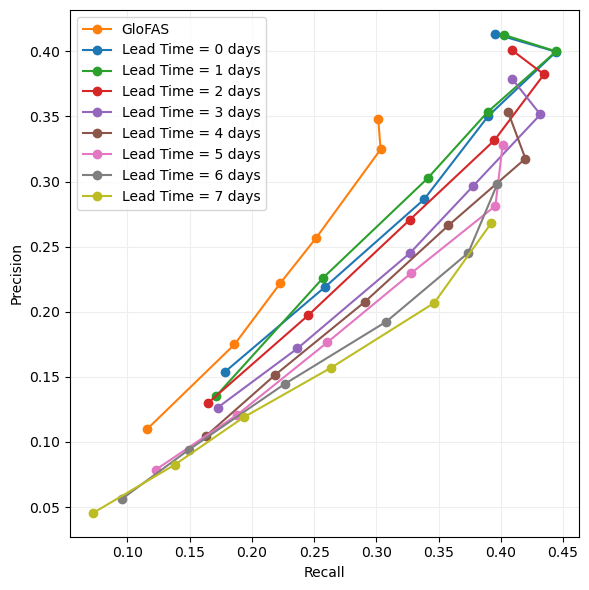

In [10]:
google_dataset = 'google_2014'
google_experiment = 'kfold_splits'
glofas_dataset = 'glofas_1980'
glofas_experiment = metrics_utils.GLOFAS_VARIABLE

fig = plt.figure(figsize=(6, 6))

lead_time = 0
d1 = {
    'recall': recalls_by_lead_time[google_dataset][google_experiment][lead_time],
    'precision': precisions_by_lead_time[google_dataset][google_experiment][lead_time],
}
d2 = {
    'recall': recalls_by_lead_time[glofas_dataset][glofas_experiment][lead_time],
    'precision': precisions_by_lead_time[glofas_dataset][glofas_experiment][lead_time]
}
df1 = pd.concat(d1, axis=1, keys=d1.keys())
df2 = pd.concat(d2, axis=1, keys=d2.keys())
df = pd.concat({google_experiment: df1, glofas_experiment: df2}, axis=1, keys=[google_experiment, glofas_experiment])

idx = pd.IndexSlice
plt.plot(
    df[idx[glofas_experiment, 'recall']].mean(),
    df[idx[glofas_experiment, 'precision']].mean(),
    'o-',
    c=evaluation_utils.EXPERIMENT_COLORS[glofas_experiment],
    label='GloFAS'
)

plt.plot(
    df[idx[google_experiment, 'recall']].mean(),
    df[idx[google_experiment, 'precision']].mean(),
    'o-',
    c=evaluation_utils.EXPERIMENT_COLORS[google_experiment],
    label=f'Lead Time = {lead_time} days'
)

for lead_time in data_paths.LEAD_TIMES[1:]:

    d1 = {
        'recall': recalls_by_lead_time[google_dataset][google_experiment][lead_time],
        'precision': precisions_by_lead_time[google_dataset][google_experiment][lead_time],
    }
    df = pd.concat(d1, axis=1, keys=d1.keys())

    color_idx = lead_time
    if lead_time > 0:
        color_idx = lead_time + 1

    plt.plot(
        df[idx['recall']].mean(),
        df[idx['precision']].mean(),
        'o-',
        c=evaluation_utils.COLORS[color_idx],
        label=f'Lead Time = {lead_time} days'
      )

plt.grid(c='#EEE')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
plt.show()